/tmp/ipykernel_95441/182718863.py:7: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/home/cassandra/Willapa/SWASH1D-turb-2/SWASH1D-turb-2.nc')


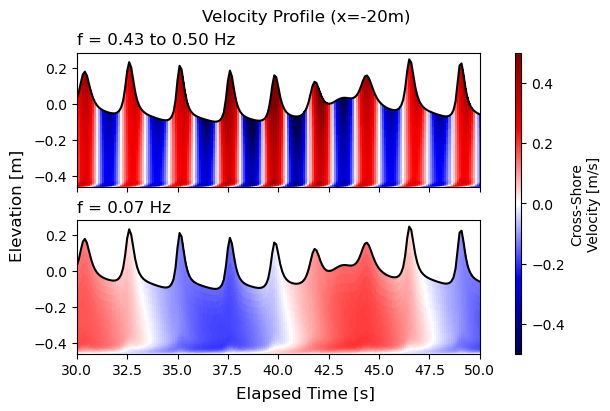

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.fftpack import fft, fftshift, fftfreq, ifft

# Read Output File
ds = xr.open_dataset('/home/cassandra/Willapa/SWASH1D-turb-2/SWASH1D-turb-2.nc')

# Cross-shore location to plot at
x0 = -20
xi = np.argmin(np.abs(ds.x.values - x0))

# Time in seconds (float dtype)
tf = ds.t.values.astype(float)/1e9

# Boundary Condition Frequencies
P1, P2 = 2.326, 2.0 

# Evaluate frequencies for low/high pass filtering
freq = fftfreq(len(ds.t), d=0.1)
df = freq[1] - freq[0]

# Note: NOT REAL IG/SS FREQUENCIES
f_ss_1 = 1/P1
f_ss_2 = 1/P2
is_ss = np.logical_and(np.abs(freq) > f_ss_1 - 2*df, 
                       np.abs(freq) < f_ss_2 + 2*df)

f_ig = (1/P2 - 1/P1)
is_ig = np.logical_and(np.abs(freq) > f_ig - 2*df, 
                       np.abs(freq) < f_ig + 2*df)

# Filter
F_u = fft(ds.u.values, axis=1)

F_u_ss = np.copy(F_u)
F_u_ss[:,~is_ss,:] = 0
u_ss = np.real(ifft(F_u_ss, axis=1))

F_u_ig = np.copy(F_u)
F_u_ig[:,~is_ig,:] = 0
u_ig = np.real(ifft(F_u_ig, axis=1))

# Plot
fig, axs = plt.subplots(nrows=2, sharey=True, sharex=True, figsize=(6,4), constrained_layout=True)

# Plot surface elevation
axs[0].plot(tf, ds.eta[:,xi].values, color='black')
axs[1].plot(tf, ds.eta[:,xi].values, color='black')

# Plot IG and SS velocity profiles
m = axs[0].pcolormesh(tf, ds.layer_z[:,:,xi], u_ss[:,:,xi], cmap='seismic', vmin=-0.5, vmax=0.5)
m = axs[1].pcolormesh(tf, ds.layer_z[:,:,xi], u_ig[:,:,xi], cmap='seismic', vmin=-0.5, vmax=0.5)

# Labels, etc
cb = plt.colorbar(m, ax=axs, aspect=50)
cb.ax.set_ylabel("Cross-Shore\nVelocity [m/s]")
fig.suptitle("Velocity Profile (x=" + str(x0)+'m)')
axs[0].set_title("f = 0.43 to 0.50 Hz", loc='left')
axs[1].set_title("f = 0.07 Hz", loc='left')
fig.supxlabel("Elapsed Time [s]")
fig.supylabel("Elevation [m]")

# Look only at time range 30-50 seconds
plt.xlim(30, 50)
plt.show()

## Plotting profiles similar to Wheeler et al 2024 Figure 1

See below:

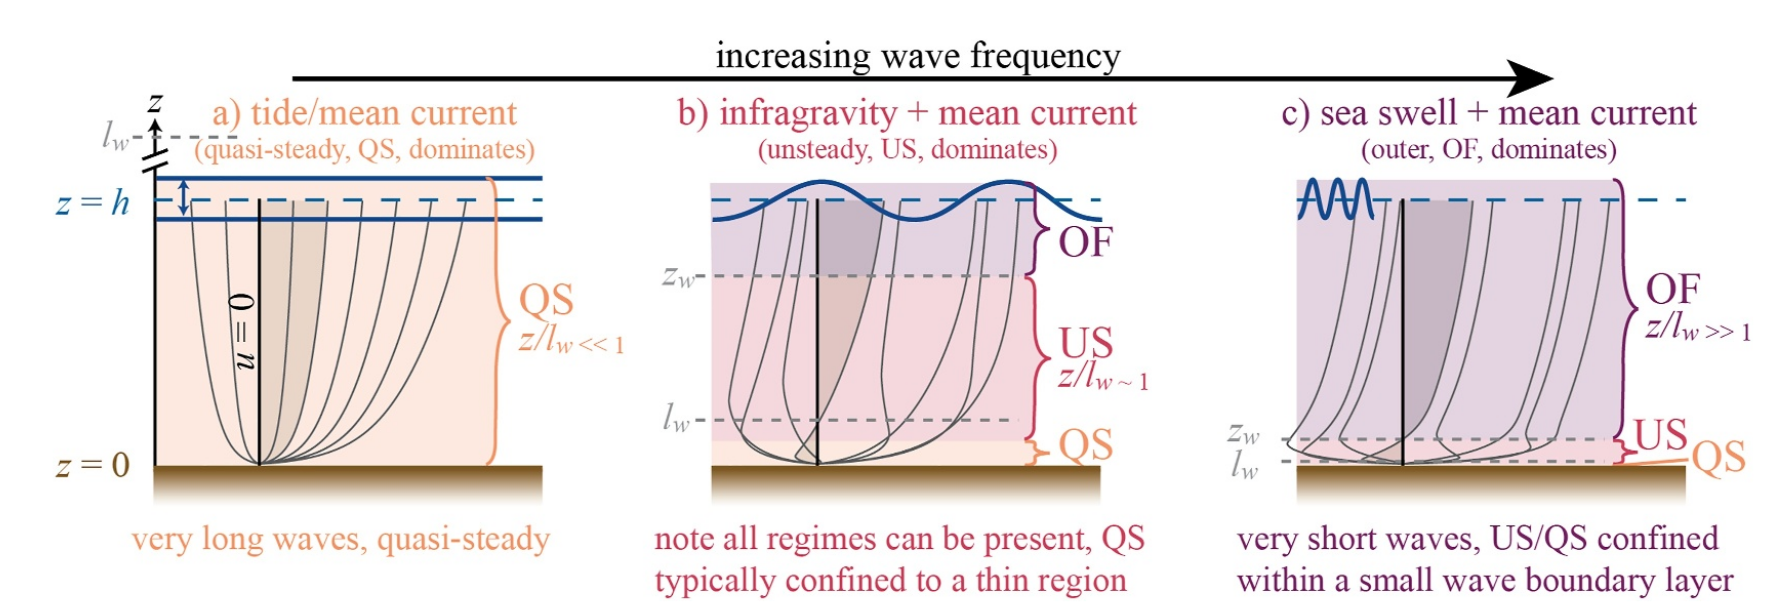

My interpretation of this: at some depth (say, 40 cm) there will be 3 frequencies: the mean, low, and high. For low and high frequencies, I'll plot one cycle (so, a few samples from some arbitrary time to some arbitrary time + 1 cycle). Then I'll add the theoretically define boundary layer length scale $l_w$. Let's start with the 3 frequencies...

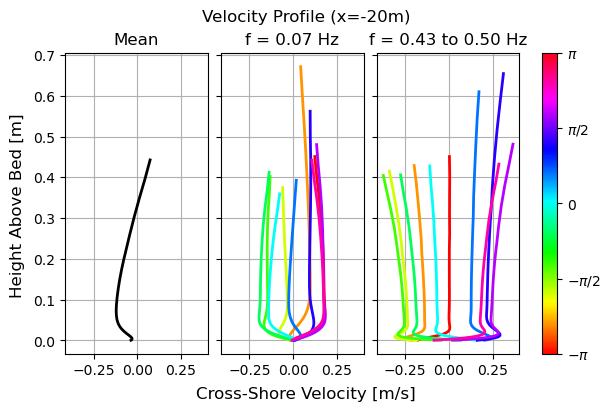

In [31]:
x0 = -20
xi = np.argmin(np.abs(ds.x.values - x0))

t0 = 450
N_periods = 1
N_lines = 10
tf_ss = t0 + 10*N_periods/((f_ss_1 + f_ss_2)/2)
tf_ig = t0 + 10*N_periods/f_ig

fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(6,4), constrained_layout=True)
fig.suptitle("Velocity Profile (x=" + str(x0)+'m)')

axs[0].plot(np.nanmean(ds.u.values, axis=1)[:,xi], 
            np.nanmean(ds.layer_z.values, axis=1)[:,xi] - ds.z_bed.values[xi],
            color='black', linewidth=2)
for ci, ti in enumerate(np.linspace(t0,tf_ig,N_lines)):
    axs[1].plot(u_ig[:,int(ti),xi], ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
for ci, ti in enumerate(np.linspace(t0,tf_ss,N_lines)):
    axs[2].plot(u_ss[:,int(ti),xi], ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
    
cb = plt.colorbar(plt.cm.ScalarMappable(cmap='hsv'), ax=axs)
cb.ax.set_yticks([0,0.25,0.5,0.75,1.0])
cb.ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
fig.supxlabel("Cross-Shore Velocity [m/s]")
fig.supylabel("Height Above Bed [m]")
axs[0].set_title("Mean")
axs[1].set_title("f = 0.07 Hz")
axs[2].set_title("f = 0.43 to 0.50 Hz")
for a in axs:
    a.grid(True)
plt.show()

My observations: 
1. In the mean, there is clearly an undertow & stokes drift. The appearance of this subplot is a little maddening, considering the average is net *away* from shore, even though there must be setup. But its the average layer velocity, whereas layer position is variable and coupled to layer velocity. So the mean here is something weird and nonlinear. I'll let this slide for now. This same problem could be the case for all plots... maybe something to be fixed if we really get into it later. 
2. Also, I note the average bed velocity does *not* go to zero. This deviation from theory suggests either the 40 layers is not adequate to resolve all physics in the boundary layer. 
3. For wave frequencies, the result is similar to Wheeler et al 2024, complete with phase lags and a boundary layer. 
4. However, they don't look like a wave profile plus the average (whatever the average is or should be) -- that's fine because I filtered them and didn't add the mean back in, but instead they're slanted outward or inward depending on phase. That could be nonlinearity (i.e. harmonics) or a limitation of the shallow water approximation. Next I'll add the mean in...

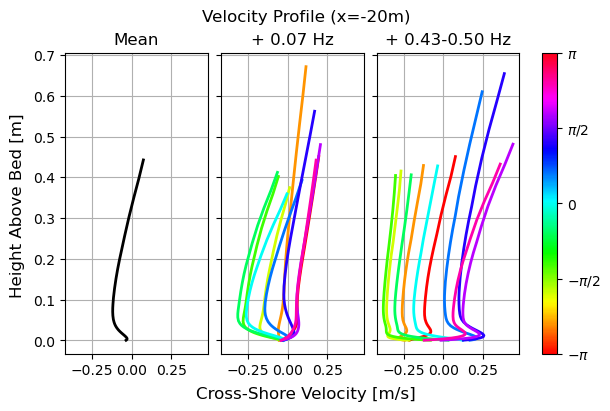

In [35]:
x0 = -20
xi = np.argmin(np.abs(ds.x.values - x0))

t0 = 450
N_periods = 1
N_lines = 10
tf_ss = t0 + 10*N_periods/((f_ss_1 + f_ss_2)/2)
tf_ig = t0 + 10*N_periods/f_ig

fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(6,4), constrained_layout=True)
fig.suptitle("Velocity Profile (x=" + str(x0)+'m)')

MEAN = np.nanmean(ds.u.values, axis=1)[:,xi]
axs[0].plot(MEAN, 
            np.nanmean(ds.layer_z.values, axis=1)[:,xi] - ds.z_bed.values[xi],
            color='black', linewidth=2)
for ci, ti in enumerate(np.linspace(t0,tf_ig,N_lines)):
    axs[1].plot(u_ig[:,int(ti),xi] + MEAN, ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
for ci, ti in enumerate(np.linspace(t0,tf_ss,N_lines)):
    axs[2].plot(u_ss[:,int(ti),xi] + MEAN, ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
    
cb = plt.colorbar(plt.cm.ScalarMappable(cmap='hsv'), ax=axs)
cb.ax.set_yticks([0,0.25,0.5,0.75,1.0])
cb.ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
fig.supxlabel("Cross-Shore Velocity [m/s]")
fig.supylabel("Height Above Bed [m]")
axs[0].set_title("Mean")
axs[1].set_title("+ 0.07 Hz")
axs[2].set_title("+ 0.43-0.50 Hz")
for a in axs:
    a.grid(True)
plt.show()

That's around what I expected... albeit, the wrong direction...

## Getting $l_w$ and $z_w$

The equation for the boundary layer lengthscale is
$$
l_w = \frac{\kappa u_{*,abs}}{\omega}
$$
where
$$
u_{*,abs}=\sqrt{\frac{\bar{|\tau_0|}}{\rho}}
$$
and $\kappa$ is the von Karman constant, $=0.41$, and $\bar{|\tau_0|}$ is the time averaged magnitude of the instantaneous bottom stress. 

It would seem one of the following are necessary:
1. Run SWASH again, outputting the bed stress.
2. Compute the bed stress from a shallow water, linearized Manning friction
3. Try to use an equation in Duncan's paper, probably by fitting a logarithmic velocity profile to the observed profile near the bottom and then back-calculating bed stress

I'm going to do #2, as a compromise between difficult computations and "model magic"...

One way of writing Manning's equation, assuming an infinitely wide channel, is to assume the hydraulic radius is just the depth (this is done in some papers at least):
$$
\tau dA = \frac{1}{2}\rho u^2 (2 g n^2 h^{7/4}) dA
$$
where $u$ is, presumably, the average velocity. I wrote it in the form of a drag/resistance problem. 

One wonders though how the bed even *knows* what the velocity high above the bed is -- or... what the depth even is. It would seem the only velocity it *knows* about is the logarithmic velocity. I am guessing either its an ok approximation or the error will be small enough to at least compare things to what I'm looking at...

In [40]:
u_mean = (np.nansum(ds.u.values[1:] * np.diff(ds.layer_z.values, axis=0), axis=0)
          /                 np.nansum(np.diff(ds.layer_z.values, axis=0), axis=0))

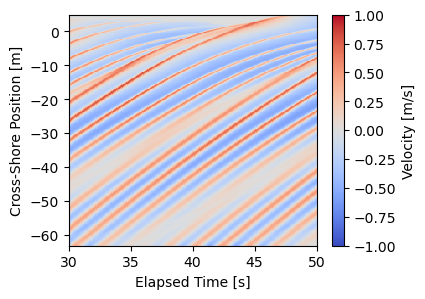

In [48]:
plt.figure(figsize=(4,3))
cf = plt.pcolormesh(tf, ds.x.values, u_mean.T, cmap='coolwarm', vmax=1, vmin=-1)
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Velocity [m/s]")
plt.xlabel("Elapsed Time [s]")
plt.ylabel("Cross-Shore Position [m]")
plt.xlim(30, 50)
plt.show()

In [58]:
rho = 1025
h = ds.eta.values - ds.z_bed.values
n = 0.019
g = 9.81

tau = rho * u_mean**2 * g * n**2 * (h)**(7/4)

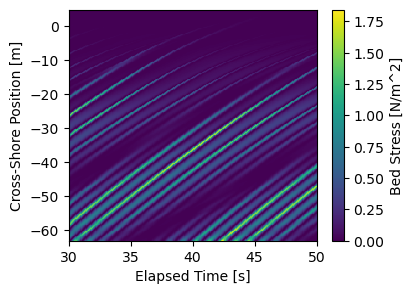

In [59]:
plt.figure(figsize=(4,3))
cf = plt.pcolormesh(tf, ds.x.values, tau.T)
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Bed Stress [N/m^2]")
plt.xlabel("Elapsed Time [s]")
plt.ylabel("Cross-Shore Position [m]")
plt.xlim(30, 50)
plt.show() 

Now I filter for the mean, the 0.07 Hz and the 0.466 Hz stress term.

In [80]:
tau_mean = np.nanmean(tau, axis=0)
F_tau = fft(tau, axis=0)

F_tau_ss = np.copy(F_tau)
F_tau_ss[~is_ss,:] = 0
tau_ss = np.real(ifft(F_tau_ss, axis=0))

F_tau_ig = np.copy(F_tau)
F_tau_ig[~is_ig,:] = 0
tau_ig = np.real(ifft(F_tau_ig, axis=0))

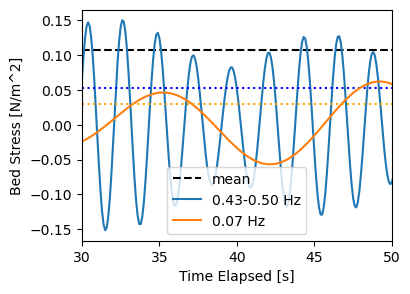

In [96]:
plt.figure(figsize=(4,3))
plt.axhline(tau_mean[xi], color='black', linestyle='--', label='mean')
plt.plot(tf, tau_ss[:,xi], label='0.43-0.50 Hz')
plt.axhline(np.nanmean(np.abs(tau_ss[:,xi])), linestyle=':', color='blue')
plt.plot(tf, tau_ig[:,xi], label='0.07 Hz')
plt.axhline(np.nanmean(np.abs(tau_ig[:,xi])), linestyle=':', color='orange')
plt.xlim(30, 50)
plt.xlabel("Time Elapsed [s]")
plt.ylabel("Bed Stress [N/m^2]")
plt.legend()
plt.show()

Well.... let's try it. 

In [100]:
u_star_mean = np.sqrt(tau_mean / rho)
u_star_ss   = np.sqrt(np.nanmedian(np.abs(tau_ss), axis=0) / rho)
u_star_ig   = np.sqrt(np.nanmedian(np.abs(tau_ig), axis=0) / rho)

kappa = 0.41

# the simulation length??
T_mean = 120
f_mean = 1 / T_mean
omega_mean = 2*np.pi*f_mean 

omega_ss = np.pi*(f_ss_1 + f_ss_2)
omega_ig = 2*np.pi*f_ig

l_w_mean = kappa * u_star_mean / omega_mean
l_w_ss = kappa * u_star_ss / omega_ss
l_w_ig = kappa * u_star_ig / omega_ig

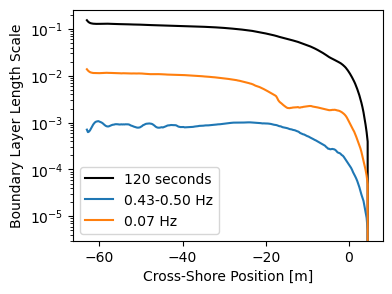

In [101]:
plt.figure(figsize=(4,3))
plt.plot(ds.x.values, l_w_mean, color='black', label='120 seconds')
plt.plot(ds.x.values, l_w_ss, label='0.43-0.50 Hz')
plt.plot(ds.x.values, l_w_ig, label='0.07 Hz')
plt.legend()
plt.yscale('log')
plt.ylabel("Boundary Layer Length Scale")
plt.xlabel("Cross-Shore Position [m]")
plt.show()

Now, the moment of truth...

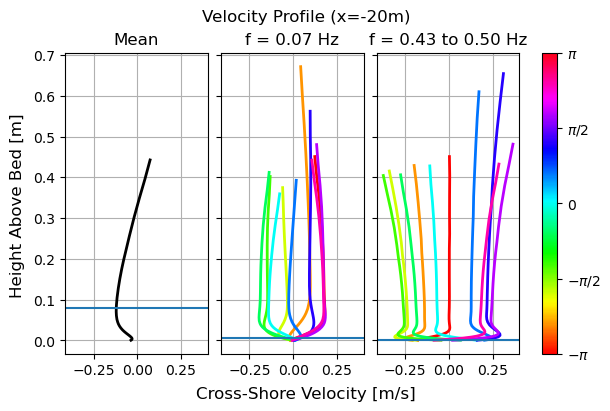

In [102]:
fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(6,4), constrained_layout=True)
fig.suptitle("Velocity Profile (x=" + str(x0)+'m)')

axs[0].plot(np.nanmean(ds.u.values, axis=1)[:,xi], 
            np.nanmean(ds.layer_z.values, axis=1)[:,xi] - ds.z_bed.values[xi],
            color='black', linewidth=2)
axs[0].axhline(l_w_mean[xi])

for ci, ti in enumerate(np.linspace(t0,tf_ig,N_lines)):
    axs[1].plot(u_ig[:,int(ti),xi], ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
axs[1].axhline(l_w_ig[xi])

for ci, ti in enumerate(np.linspace(t0,tf_ss,N_lines)):
    axs[2].plot(u_ss[:,int(ti),xi], ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
axs[2].axhline(l_w_ss[xi])

cb = plt.colorbar(plt.cm.ScalarMappable(cmap='hsv'), ax=axs)
cb.ax.set_yticks([0,0.25,0.5,0.75,1.0])
cb.ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
fig.supxlabel("Cross-Shore Velocity [m/s]")
fig.supylabel("Height Above Bed [m]")
axs[0].set_title("Mean")
axs[1].set_title("f = 0.07 Hz")
axs[2].set_title("f = 0.43 to 0.50 Hz")
for a in axs:
    a.grid(True)
plt.show()

It seems very underestimated. What if instead I just plug in the max velocity for u star?

In [103]:
l_w_mean_2 = kappa * np.nanmax(np.nanmean(ds.u.values, axis=1)[:,xi]) / omega_mean
l_w_ss_2 = kappa * np.nanmax(u_ss[:,:,xi]) / omega_ss
l_w_ig_2 = kappa * np.nanmax(u_ig[:,:,xi]) / omega_ig

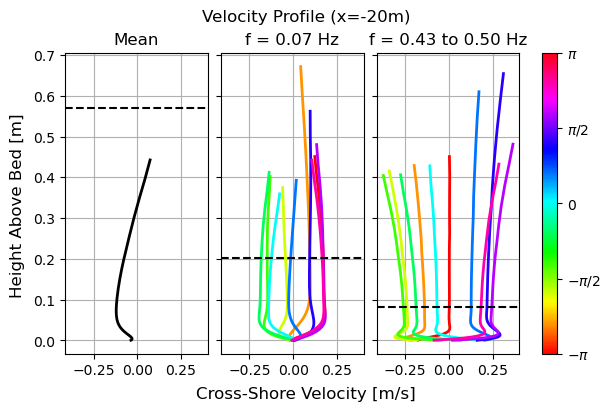

In [104]:
fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(6,4), constrained_layout=True)
fig.suptitle("Velocity Profile (x=" + str(x0)+'m)')

axs[0].plot(np.nanmean(ds.u.values, axis=1)[:,xi], 
            np.nanmean(ds.layer_z.values, axis=1)[:,xi] - ds.z_bed.values[xi],
            color='black', linewidth=2)
axs[0].axhline(l_w_mean_2, color='black', linestyle='--')

for ci, ti in enumerate(np.linspace(t0,tf_ig,N_lines)):
    axs[1].plot(u_ig[:,int(ti),xi], ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
axs[1].axhline(l_w_ig_2, color='black', linestyle='--')

for ci, ti in enumerate(np.linspace(t0,tf_ss,N_lines)):
    axs[2].plot(u_ss[:,int(ti),xi], ds.layer_z[:,int(ti),xi] - ds.z_bed[xi],
               color=plt.cm.hsv(ci*N_periods/N_lines % 1), linewidth=2)
axs[2].axhline(l_w_ss_2, color='black', linestyle='--')

cb = plt.colorbar(plt.cm.ScalarMappable(cmap='hsv'), ax=axs)
cb.ax.set_yticks([0,0.25,0.5,0.75,1.0])
cb.ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
fig.supxlabel("Cross-Shore Velocity [m/s]")
fig.supylabel("Height Above Bed [m]")
axs[0].set_title("Mean")
axs[1].set_title("f = 0.07 Hz")
axs[2].set_title("f = 0.43 to 0.50 Hz")
for a in axs:
    a.grid(True)
plt.show()

Better!! But still kinda crazy.

## Conclusions

1. One could dig into how the physical terms are determined, necessary to proceed further in Duncan's paper. I've gone far enough to get the picture but calculating turbulent dissipation from SWASH outputs will require more work getting each term just right. Also, it would make sense to have the model output terms as necessary...
2. Also, how exactly Manning's equation is implemented in the model would be good to know. I'm not satisfied by this calculation.
3. I suppose I want to fix it and then see how it changes under varying location, possibly for an applied purpose, but this is as far as I take it for now. 